In [2]:
# ! pip install pandas matplotlib tensorflow

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd

## Sentiment analysis with Python

https://techvidvan.com/tutorials/python-sentiment-analysis/

#### Getting our data

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?resource=download

In [2]:
df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Gather/clean data we need and explore df

In [3]:
review_df = df[['text','airline_sentiment']]

print(review_df.shape)
review_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [4]:
# column names
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
# Check airline_sentiment column counts
review_df = review_df[review_df['airline_sentiment'] != 'neutral']  # remove neutral sentiments
review_df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
# convert categorical values to numeric w/ factorize
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

### Using Tensorflow to building sentiment analysis model

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
tweet = review_df.text.values
tweet

array(["@VirginAmerica plus you've added commercials to the experience... tacky.",
       '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
       "@VirginAmerica and it's a really big bad thing about it", ...,
       '@AmericanAir thank you we got on a different flight to Chicago.',
       "@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc",
       "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"],
      dtype=object)

#### Build tokenizer

In [10]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)  ## assign dictionary of words and tokenized numbers
encoded_docs = tokenizer.texts_to_sequences(tweet) ## replace words with assigned numbers
padded_sequence = pad_sequences(encoded_docs, maxlen=200) ## allow for equal length of all tweets
padded_sequence

array([[   0,    0,    0, ...,    1,    2,  177],
       [   0,    0,    0, ...,   25,  482, 2417],
       [   0,    0,    0, ...,  483,   86,   21],
       ...,
       [   0,    0,    0, ...,    8,    1,  480],
       [   0,    0,    0, ..., 1682,   45,  945],
       [   0,    0,    0, ...,  144,   11, 2325]])

#### Build text classifier

In [11]:
## Long Short Term Memory (LSTM) Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [12]:
embedding_vector_length = 32
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
__________________________________________________

### Training our sentiment analysis model

In [13]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 34s 111ms/step - loss: 0.3918 - accuracy: 0.8377 - val_loss: 0.2196 - val_accuracy: 0.9259
Epoch 2/5
289/289 [==============================] - 34s 119ms/step - loss: 0.2205 - accuracy: 0.9142 - val_loss: 0.1609 - val_accuracy: 0.9441
Epoch 3/5
289/289 [==============================] - 35s 121ms/step - loss: 0.1622 - accuracy: 0.9397 - val_loss: 0.1579 - val_accuracy: 0.9480
Epoch 4/5
289/289 [==============================] - 35s 122ms/step - loss: 0.1333 - accuracy: 0.9489 - val_loss: 0.1719 - val_accuracy: 0.9402
Epoch 5/5
289/289 [==============================] - 34s 118ms/step - loss: 0.1106 - accuracy: 0.9607 - val_loss: 0.1905 - val_accuracy: 0.9467


#### Accuracy plot

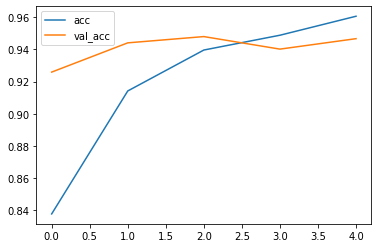

In [14]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

#### Loss plot

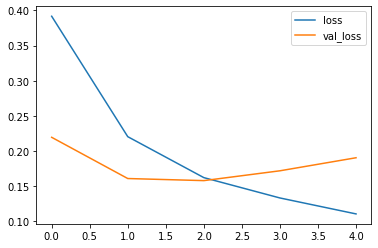

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Analysis prior to using model
Our model achieved a model accuracy of 96.07%, and value accuracy of 94.67%. We can use this model to determine sentiments from customer tweets with confidence.

### Using our model

In [16]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])


test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 174ms/step
Predicted label:  positive
1/1 [==============================] - 0s 23ms/step
Predicted label:  negative


### Overall analysis
We can conclude our model does a great job predicting the positive and negative sentiment of a tweet about an airline. This specialized model can be a great tool for airlines to see trends in the market. Southwest can use a tool like this that's tailored to customer sentiment and delays. Competitors can track when this happens and hop on a marketing campaign. They can also use it to check their systems and ensure they don't put customers in similar positions.